dat shape (neurons x trials): (39209, 5900)

PCA: 15 components explain ≥90% of the variance in the test set.


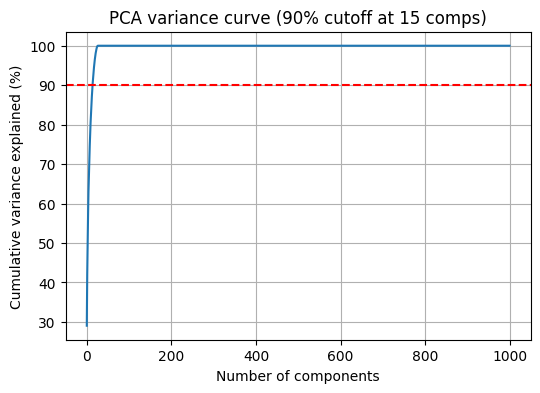


Computed metrics for 500 neurons.
At FDR=0.05, 2/500 neurons show AUC > 0.5 (significant).


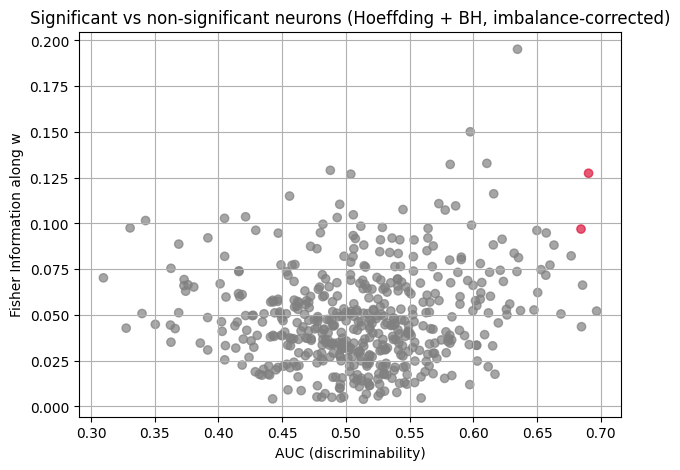


Summary statistics:
                     mean           std           min           max
neuron_idx   19525.856000  11244.473146  2.070000e+02  39154.000000
AUC              0.511915      0.064887  3.097151e-01      0.696717
Advantage        0.023829      0.129773 -3.805698e-01      0.393435
FI_trace       233.056953     10.022081  1.579719e+02    247.636942
FI_along_w       0.048515      0.026426  3.933911e-03      0.195228
EffectiveFI      0.001644      0.008811 -3.304013e-02      0.052569
m_pos           68.450000     52.662645  1.200000e+01    367.000000
n_neg         1331.550000     52.662645  1.033000e+03   1388.000000
p_value          0.831841      0.271589  7.683413e-07      1.000000
p_adj            0.987850      0.102947  3.841707e-04      1.000000

Top 10 significant neurons (imbalance-corrected):
     neuron_idx       AUC  m_pos  n_neg       p_value     p_adj
78        32302  0.690380    233   1167  7.683413e-07  0.000384
100       27167  0.684463    191   1209  1.333879e-0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import pickle, warnings

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split by image identity (avoid leakage across trials)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  Transform data
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)        # spike indicator
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    """Compute Fisher Information matrix for fitted logistic regression."""
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    """Return AUC and classifier advantage (2*(AUC-0.5))."""
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Global PCA (before per-neuron loop)
# ---------------------------------------------------------------
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"\nPCA: {n_components_90} components explain ≥90% of the variance in the test set.")

# Fit PCA on training data (with that fixed dimensionality)
pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])

# Transform once
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# Optional visualization of explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance explained (%)')
plt.title(f'PCA variance curve (90% cutoff at {n_components_90} comps)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Run per-neuron logistic regressions
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue

    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )

    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test_pca)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)

    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)

    m_pos = y_test.sum()
    n_neg = len(y_test) - m_pos
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI,
        "m_pos": m_pos,
        "n_neg": n_neg,
        "p_value": p_val
    })

# ---------------------------------------------------------------
#  Analysis: Benjamini–Hochberg correction
# ---------------------------------------------------------------
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons.")

alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")
df["p_adj"] = pvals_corrected
df["significant"] = reject

n_sig = df["significant"].sum()
print(f"At FDR={alpha}, {n_sig}/{len(df)} neurons show AUC > 0.5 (significant).")

# ---------------------------------------------------------------
#  Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True:"crimson", False:"gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH, imbalance-corrected)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Reports
# ---------------------------------------------------------------
print("\nSummary statistics:")
print(df.describe().T[["mean","std","min","max"]])

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (imbalance-corrected):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])

top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])
